## Experimento No 5 - Boosting con MCA y Target Encoding

**Notes:**

- Ordinal encoding for Tree-based models
- Frequency encoding is commonly used in NLP
- Target encoding could perform better that any other encoder for HC
- We could try to use a HCT to see if a model does better or not
- When dealing with HC features we can group rare categories into one to avoid overfitting or any problems at training time

### Load data and import libraries

In [2]:
# In case you're running this in colab
# !pip install pycaret
# !pip install dython

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
import warnings
%matplotlib inline

from sklearn.preprocessing import TargetEncoder, LabelEncoder, OrdinalEncoder
from pycaret.classification import setup, compare_models
import joblib

RANDOM_SEED = 42 # For reproducibility

sns.set_palette('dark')
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50)

In [4]:
df_train_full = pd.read_csv('data/train.csv')
df_test_full = pd.read_csv('data/test.csv')
df_train_full.head().T

,0,1,2,3,4
ID,904256,645256,308367,470353,989032
PERIODO,20212,20212,20203,20195,20212
ESTU_PRGM_ACADEMICO,ENFERMERIA,DERECHO,MERCADEO Y PUBLICIDAD,ADMINISTRACION DE EMPRESAS,PSICOLOGIA
ESTU_PRGM_DEPARTAMENTO,BOGOTÁ,ATLANTICO,BOGOTÁ,SANTANDER,ANTIOQUIA
ESTU_VALORMATRICULAUNIVERSIDAD,Entre 5.5 millones y menos de 7 millones,Entre 2.5 millones y menos de 4 millones,Entre 2.5 millones y menos de 4 millones,Entre 4 millones y menos de 5.5 millones,Entre 2.5 millones y menos de 4 millones
ESTU_HORASSEMANATRABAJA,Menos de 10 horas,0,Más de 30 horas,0,Entre 21 y 30 horas
FAMI_ESTRATOVIVIENDA,Estrato 3,Estrato 3,Estrato 3,Estrato 4,Estrato 3
FAMI_TIENEINTERNET,Si,No,Si,Si,Si
FAMI_EDUCACIONPADRE,Técnica o tecnológica incompleta,Técnica o tecnológica completa,Secundaria (Bachillerato) completa,No sabe,Primaria completa
FAMI_TIENELAVADORA,Si,Si,Si,Si,Si


In [5]:
df_train_full.shape

(692500, 17)

### EDA

In [6]:
df_analysis = df_train_full.copy()
df_analysis.drop('ID', axis=1, inplace=True)
df_analysis['PERIODO'] = df_analysis['PERIODO'].astype(str).apply(lambda text: text[:4])

df_analysis.isna().sum()

PERIODO                               0
ESTU_PRGM_ACADEMICO                   0
ESTU_PRGM_DEPARTAMENTO                0
ESTU_VALORMATRICULAUNIVERSIDAD     6287
ESTU_HORASSEMANATRABAJA           30857
FAMI_ESTRATOVIVIENDA              32137
FAMI_TIENEINTERNET                26629
FAMI_EDUCACIONPADRE               23178
FAMI_TIENELAVADORA                39773
FAMI_TIENEAUTOMOVIL               43623
ESTU_PRIVADO_LIBERTAD                 0
ESTU_PAGOMATRICULAPROPIO           6498
FAMI_TIENECOMPUTADOR              38103
FAMI_TIENEINTERNET.1              26629
FAMI_EDUCACIONMADRE               23664
RENDIMIENTO_GLOBAL                    0
dtype: int64

In [7]:
df_analysis.describe(include='object')

,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL
count,692500,692500,692500,686213,661643,660363,665871,669322,652727,648877,692500,686002,654397,665871,668836,692500
unique,4,948,31,8,5,7,2,12,2,2,2,2,2,2,12,4
top,2019,DERECHO,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,Más de 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,alto
freq,182510,53244,282159,204048,249352,232671,592514,128289,563390,412606,692466,382201,597670,592514,141744,175619


In [8]:
df_analysis['FAMI_EDUCACIONMADRE'].unique()

array(['Postgrado', 'Técnica o tecnológica incompleta',
       'Secundaria (Bachillerato) completa', 'Primaria completa',
       'Técnica o tecnológica completa',
       'Secundaria (Bachillerato) incompleta',
       'Educación profesional incompleta',
       'Educación profesional completa', 'Primaria incompleta', nan,
       'Ninguno', 'No Aplica', 'No sabe'], dtype=object)

In [9]:
df_analysis['FAMI_ESTRATOVIVIENDA'].unique()

array(['Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 2', 'Estrato 1',
       nan, 'Estrato 6', 'Sin Estrato'], dtype=object)

In [10]:
df_analysis['ESTU_VALORMATRICULAUNIVERSIDAD'].value_counts()

ESTU_VALORMATRICULAUNIVERSIDAD
Entre 1 millón y menos de 2.5 millones      204048
Entre 2.5 millones y menos de 4 millones    127430
Menos de 500 mil                             80263
Entre 500 mil y menos de 1 millón            78704
Entre 4 millones y menos de 5.5 millones     69736
Más de 7 millones                            68014
Entre 5.5 millones y menos de 7 millones     38490
No pagó matrícula                            19528
Name: count, dtype: int64

In [11]:
df_analysis['ESTU_HORASSEMANATRABAJA'].value_counts()

ESTU_HORASSEMANATRABAJA
Más de 30 horas        249352
0                      116550
Entre 11 y 20 horas    115857
Entre 21 y 30 horas     92693
Menos de 10 horas       87191
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='ESTU_VALORMATRICULAUNIVERSIDAD'>

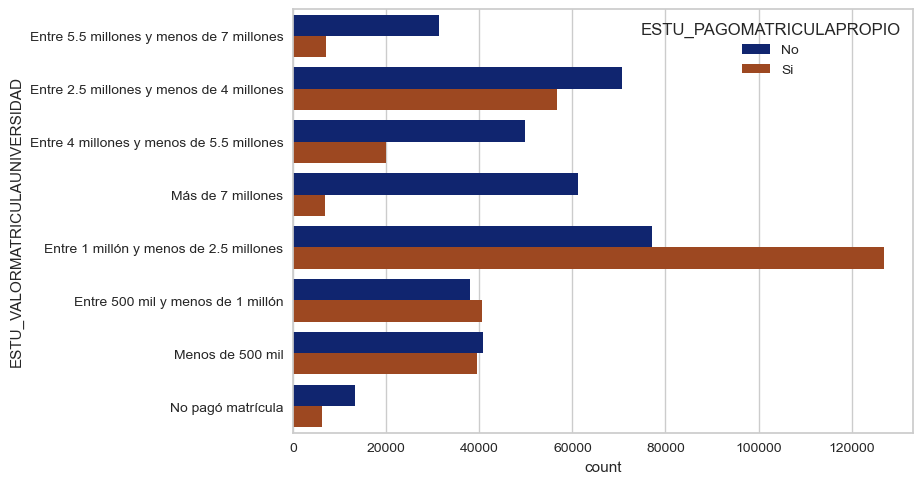

In [12]:
sns.countplot(df_analysis, y='ESTU_VALORMATRICULAUNIVERSIDAD', hue='ESTU_PAGOMATRICULAPROPIO')

### Correlation Pre-processing

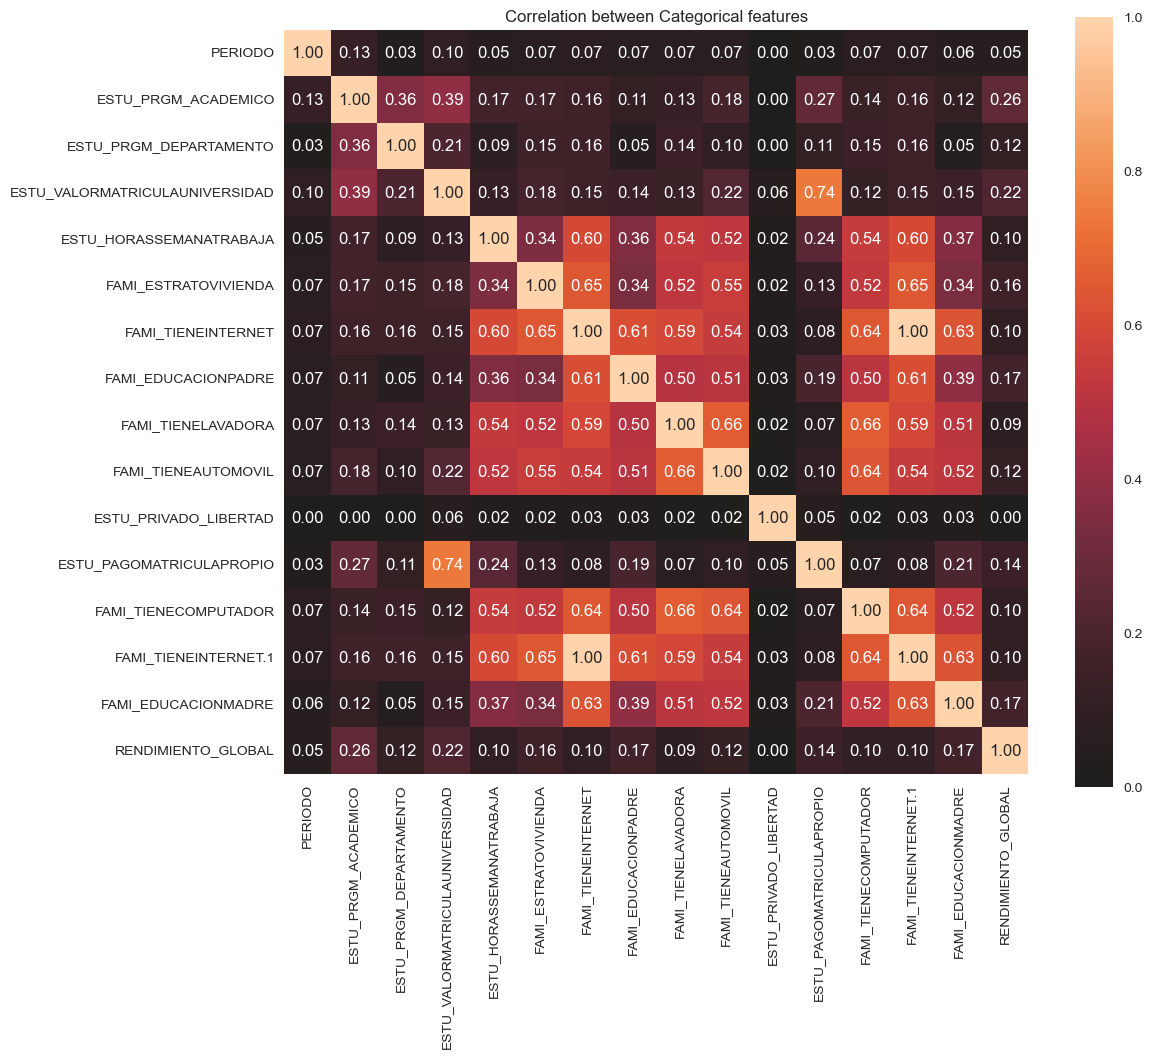

In [13]:
associations(df_analysis, figsize=(12, 10), title='Correlation between Categorical features')
plt.show()

### Preprocessing

#### Cleaning Features
- Drop `ID` and `FAMI_TIENEINTERNET.1` which is duplicated
- Remove weird characters in `ESTU_PGRM_ACADEMICO`, group rare values into one category
- Do feature engineering to `EDUCACIONPADRE - MADRE` **(Next experiment)**
- Replace 0 for 'No trabaja' in `ESTU_HORASSEMANATRABAJA`


In [14]:
def clean_data(df: pd.DataFrame): 
    new_df = df.copy() # Create a copy

    # Drop and clean columns
    new_df.drop(['ID', 'FAMI_TIENEINTERNET.1'], axis=1, inplace=True)
    new_df['PERIODO'] = new_df['PERIODO'].astype(str).apply(lambda text: text[:4])

    return new_df

# Clean data in both train and test
df_train = clean_data(df_train_full)
df_test = clean_data(df_test_full)

In [15]:
def normalize_text(text: str):
    """Removes any weird character like accents from a string"""
    import unicodedata

    if not pd.isna(text):
        return (
            unicodedata.normalize('NFKD', text)
            .encode('ASCII', 'ignore')
            .decode('utf-8')
        )
    return text

def group_rare_values(data: pd.DataFrame, col: str, threshold: float = 0.01):
    """Groups rare values into a unique category"""
    percentajes = data[col].value_counts(normalize=True)
    group_values = lambda value: 'OTRO' if percentajes[value] < threshold else value

    return data[col].apply(group_values)
    

# Remove weird characters from values
for col in ['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']:
    df_train[col] = df_train[col].apply(normalize_text)
    df_test[col] = df_test[col].apply(normalize_text)

# Group rare values into one category
for col in ['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO']:
    df_train[col] = group_rare_values(df_train, col)
    df_test[col] = group_rare_values(df_test, col)

In [16]:
# Replace values to make more sense
df_train['ESTU_HORASSEMANATRABAJA'].replace('0', 'No trabaja', inplace=True)
df_train['FAMI_EDUCACIONPADRE'].replace(['No Aplica', 'No sabe'], 'Ninguno', inplace=True)
df_train['FAMI_EDUCACIONMADRE'].replace(['No Aplica', 'No sabe'], 'Ninguno', inplace=True)

df_test['ESTU_HORASSEMANATRABAJA'].replace('0', 'No trabaja', inplace=True)
df_test['FAMI_EDUCACIONPADRE'].replace(['No Aplica', 'No sabe'], 'Ninguno', inplace=True)
df_test['FAMI_EDUCACIONMADRE'].replace(['No Aplica', 'No sabe'], 'Ninguno', inplace=True)

#### Imputation
- There's only 6 social classes in Colombia, therefore we can use 'Sin Estrato' or mode
- Use mode for Binary Features
- Use 'No trabaja' for `ESTU_HORASSEMANATRABAJA`
- Use 'Ninguno' for `EDUCACIONPADRE - MADRE`
- Use mode for `MATRICULA` (this can change to 'No pago matricula')

In [17]:
def impute_cols(df: pd.DataFrame):
    new_df = df.copy() # Make a copy

    # Impute with own values
    new_df['FAMI_ESTRATOVIVIENDA'] = new_df['FAMI_ESTRATOVIVIENDA'].fillna('Sin Estrato')
    new_df['ESTU_HORASSEMANATRABAJA'] = new_df['ESTU_HORASSEMANATRABAJA'].fillna('No trabaja')
    new_df['FAMI_EDUCACIONPADRE'] = new_df['FAMI_EDUCACIONPADRE'].fillna('Ninguno')
    new_df['FAMI_EDUCACIONMADRE'] = new_df['FAMI_EDUCACIONMADRE'].fillna('Ninguno')

    # Select binary columns
    binary_cols = [col for col in new_df.columns if new_df[col].nunique() == 2]
    for col in binary_cols + ['ESTU_VALORMATRICULAUNIVERSIDAD']:
        col_mode = new_df[col].mode()[0]
        new_df[col] = new_df[col].fillna(col_mode)

    return new_df

df_imputed = impute_cols(df_train)

In [18]:
df_imputed.isna().sum().sum() # Verify is all values were imputed

0

In [19]:
# Impute values in training and testing datasets
df_train = impute_cols(df_train)
df_test = impute_cols(df_test)

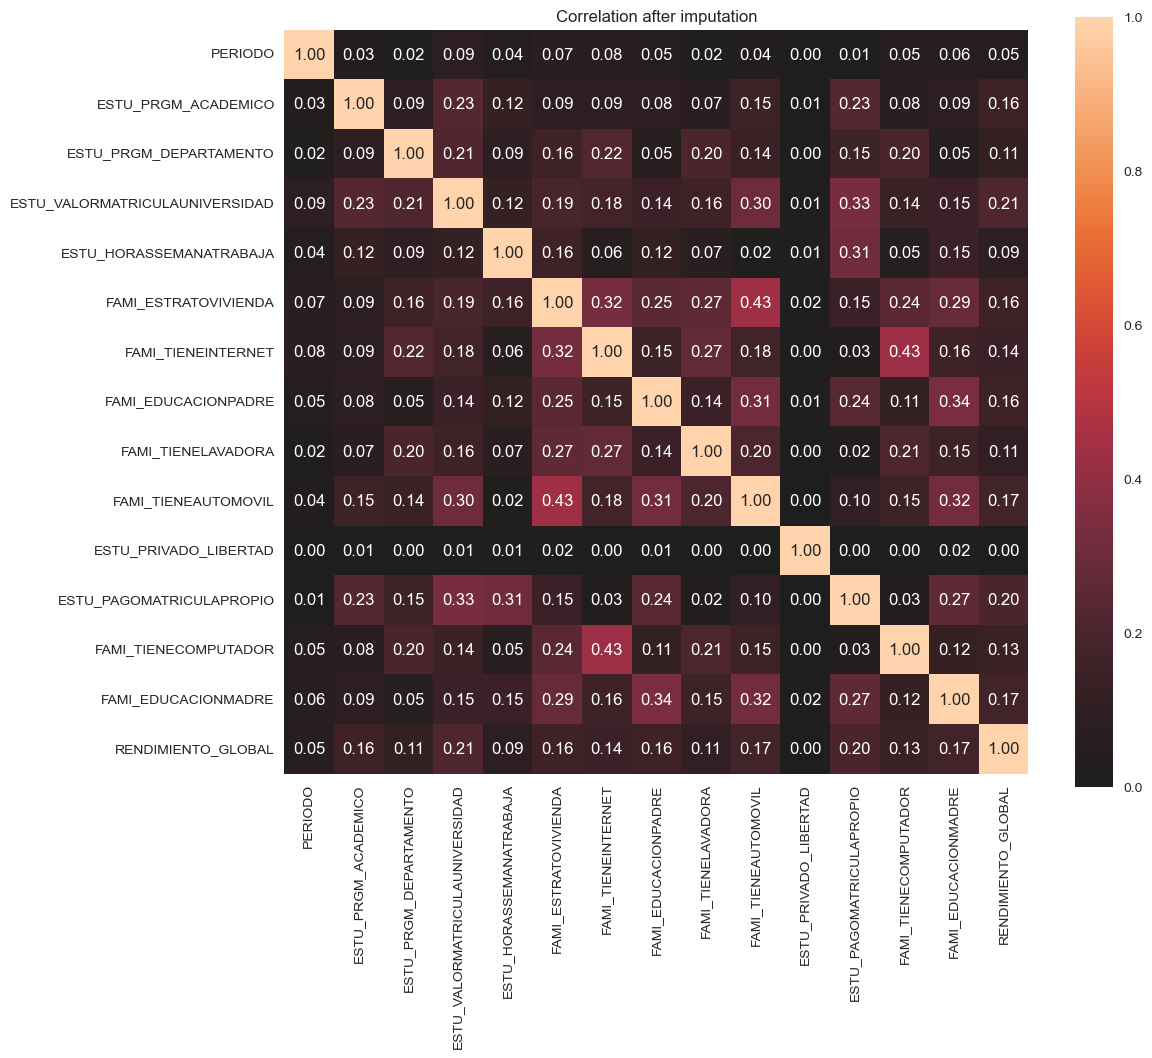

In [20]:
associations(df_train, title='Correlation after imputation', figsize=(12, 10))
plt.show()

#### Encoding
- Use **Target Encoding** on High Cardinality features
- Use **Ordinal Encoding** on `ESTRATO`, `EDUCACION`, `HORASTRABAJA`, `VALORMATRICULA`
- Use **One-Hot Encoding** on everything else

In [21]:
# Ordinal Encoding
custom_orders = [
    ['Sin Estrato', 'Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6'],
    ['No trabaja', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas'],
    ['No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón', 'Entre 1 millón y menos de 2.5 millones',
    'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones', 'Entre 5.5 millones y menos de 7 millones',
    'Más de 7 millones'],
    ['Ninguno', 'Primaria incompleta', 'Primaria completa', 'Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa',
    'Tecnica o tecnologica incompleta', 'Tecnica o tecnologica completa', 'Educacion profesional incompleta',
    'Educacion profesional completa', 'Postgrado'],
    ['Ninguno', 'Primaria incompleta', 'Primaria completa', 'Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa',
    'Tecnica o tecnologica incompleta', 'Tecnica o tecnologica completa', 'Educacion profesional incompleta',
    'Educacion profesional completa', 'Postgrado']
]

ord_cols = ['FAMI_ESTRATOVIVIENDA','ESTU_HORASSEMANATRABAJA', 'ESTU_VALORMATRICULAUNIVERSIDAD',
           'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']

ordinal_encoder = OrdinalEncoder(categories=custom_orders)

df_ord_train = pd.DataFrame(ordinal_encoder.fit_transform(df_train[ord_cols]), columns=ord_cols)
df_ord_test = pd.DataFrame(ordinal_encoder.fit_transform(df_test[ord_cols]), columns=ord_cols)

# Join new cols and remove previous non encoded cols
df_train = pd.concat([df_train.drop(columns=ord_cols, axis=1), df_ord_train], axis=1)
df_test = pd.concat([df_test.drop(columns=ord_cols, axis=1), df_ord_test], axis=1)

In [22]:
# Label encoding
label_encoder = LabelEncoder()

new_labels = pd.DataFrame(label_encoder.fit_transform(df_train['RENDIMIENTO_GLOBAL']), columns=['RENDIMIENTO_GLOBAL'])
df_train = pd.concat([df_train.drop('RENDIMIENTO_GLOBAL', axis=1), new_labels], axis=1)

In [23]:
# Target encoding
hc_cols = ['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO']

target_encoder = TargetEncoder(target_type='multiclass', random_state=RANDOM_SEED)
target_encoder.fit(df_train[hc_cols], df_train['RENDIMIENTO_GLOBAL'])
new_cols_names = target_encoder.get_feature_names_out()

high_cardinality_train = pd.DataFrame(target_encoder.transform(df_train[hc_cols]), columns=new_cols_names)
high_cardinality_test = pd.DataFrame(target_encoder.transform(df_test[hc_cols]), columns=new_cols_names)

# Remove old cols
df_train = pd.concat([df_train.drop(hc_cols, axis=1), high_cardinality_train], axis=1)
df_test = pd.concat([df_test.drop(hc_cols, axis=1), high_cardinality_test], axis=1)

In [24]:
# One-Hot Encoding
df_train = pd.get_dummies(df_train, dtype=int)
df_test = pd.get_dummies(df_test, dtype=int)

## Model Training
Using pycaret so we can try different models and choose which we'll for future experiments.

**Note:** This cells take around 5 minutes to run

In [25]:
# Set up the experiment
_ = setup(
    data=df_train,
    target='RENDIMIENTO_GLOBAL',
    session_id=RANDOM_SEED,
    preprocess=False
)

,Description,Value
0,Session id,42
1,Target,RENDIMIENTO_GLOBAL
2,Target type,Multiclass
3,Original data shape,"(692500, 30)"
4,Transformed data shape,"(692500, 30)"
5,Transformed train set shape,"(484749, 30)"
6,Transformed test set shape,"(207751, 30)"
7,Numeric features,29


In [26]:
base_model = compare_models(cross_validation=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.4239,0.6955,0.4239,0.4085,0.4122,0.2315,0.2331,3.3900
lightgbm,Light Gradient Boosting Machine,0.4228,0.6938,0.4228,0.4057,0.4090,0.2301,0.2321,3.5300
gbc,Gradient Boosting Classifier,0.4161,0.6864,0.4161,0.3997,0.4030,0.2210,0.2229,139.8500
ada,Ada Boost Classifier,0.4079,0.6677,0.4079,0.3879,0.3899,0.2100,0.2130,13.7500
lr,Logistic Regression,0.3879,0.6571,0.3879,0.3666,0.3670,0.1832,0.1867,28.9500
ridge,Ridge Classifier,0.3866,0.0000,0.3866,0.3602,0.3478,0.1810,0.1898,0.1100
rf,Random Forest Classifier,0.3774,0.6410,0.3774,0.3716,0.3739,0.1697,0.1699,10.3800
et,Extra Trees Classifier,0.3675,0.6195,0.3675,0.3603,0.3630,0.1564,0.1567,7.7500
svm,SVM - Linear Kernel,0.3640,0.0000,0.3640,0.3561,0.3155,0.1501,0.1673,1.6400
nb,Naive Bayes,0.3567,0.6373,0.3567,0.3441,0.3249,0.1409,0.1503,0.0800


In [27]:
base_model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Making Predictions

In [28]:
preds = base_model.predict(df_test)
preds

array([3, 2, 0, ..., 2, 0, 0])

In [29]:
# Decode predictions
real_preds = label_encoder.inverse_transform(preds)
real_preds

array(['medio-bajo', 'medio-alto', 'alto', ..., 'medio-alto', 'alto',
       'alto'], dtype=object)

In [30]:
# Create submission
df_submission = pd.DataFrame({
    "ID": df_test_full.ID,
    "RENDIMIENTO_GLOBAL": real_preds
})

df_submission

,ID,RENDIMIENTO_GLOBAL
0,550236,medio-bajo
1,98545,medio-alto
2,499179,alto
3,782980,bajo
4,785185,bajo
...,...,...
296781,496981,medio-bajo
296782,209415,alto
296783,239074,medio-alto
296784,963852,alto


In [31]:
# Save predictions
df_submission.to_csv('submissions/base_model_preds.csv', index=False)

In [33]:
# Save base model
joblib.dump(base_model, 'models/base_model.joblib')

['models/base_model.joblib']